In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from des_helpers import dpa_select_function

# Load preprocessed data
trace_df = pd.read_csv("des_extension_data.csv")
plaintexts = trace_df['Plaintext'].to_numpy()
powers = trace_df['Power'].to_numpy()

In [16]:
from joblib import Parallel, delayed

kc = 4

# Number of measurements
n_measurements = range(10, 1001, 10)

sr_sets = {
    "SR_1": (kc, [0]),
    "SR_2": (kc, [0,1]),
    "SR_8": (kc, [0,1,2,3,5,6,7,8]), # skip 4 since it is kc
    "SR_63": (kc, [k for k in range(64) if k != kc])
}

select_outputs_on_key = []
for i in range(64):
    select_outputs_on_key.append(np.array([dpa_select_function(pt, i) for pt in plaintexts]))

def calc_doms(keys, indexes):
    doms = {}
    for key in keys:
        sel_values = select_outputs_on_key[key][indexes]
        mask0 = sel_values == 0
        mask1 = sel_values == 1
        group0_powers = powers[indexes][mask0]
        group1_powers = powers[indexes][mask1]
        avg_group0 = np.mean(group0_powers) if group0_powers.size > 0 else 0
        avg_group1 = np.mean(group1_powers) if group1_powers.size > 0 else 0
        doms[key] = avg_group1 - avg_group0
    return doms

def trial_success(sample_indexes, kc, k_guesses):
    doms = calc_doms([kc] + k_guesses, sample_indexes)
    kc_dom = doms[kc]
    for k in k_guesses:
        if kc_dom < doms[k]:
            return False
    return True

trails = 1000
sr_data = {}

for sr in sr_sets:
    sr_data[sr] = []
    kc = sr_sets[sr][0]
    k_guesses = sr_sets[sr][1]
    
    for n in n_measurements:
        samples = [trace_df.sample(n).index for _ in range(trails)]
        results = Parallel(n_jobs=4)(
            delayed(trial_success)(sample, kc, k_guesses) for sample in samples
        )
        success_rate = sum(results) / trails
        sr_data[sr].append(success_rate)
        print(f"{sr}: num measures {n}")

SR_1: num measures 10
SR_1: num measures 20
SR_1: num measures 30
SR_1: num measures 40
SR_1: num measures 50
SR_1: num measures 60
SR_1: num measures 70
SR_1: num measures 80
SR_1: num measures 90
SR_1: num measures 100
SR_1: num measures 110
SR_1: num measures 120
SR_1: num measures 130
SR_1: num measures 140
SR_1: num measures 150
SR_1: num measures 160
SR_1: num measures 170
SR_1: num measures 180
SR_1: num measures 190
SR_1: num measures 200
SR_1: num measures 210
SR_1: num measures 220
SR_1: num measures 230
SR_1: num measures 240
SR_1: num measures 250
SR_1: num measures 260
SR_1: num measures 270
SR_1: num measures 280
SR_1: num measures 290
SR_1: num measures 300
SR_1: num measures 310
SR_1: num measures 320
SR_1: num measures 330
SR_1: num measures 340
SR_1: num measures 350
SR_1: num measures 360
SR_1: num measures 370
SR_1: num measures 380
SR_1: num measures 390
SR_1: num measures 400
SR_1: num measures 410
SR_1: num measures 420
SR_1: num measures 430
SR_1: num measures 4

In [30]:
import pickle
# Save the arrays using pickle
with open("emprical_sr.pkl", "wb") as f:
    pickle.dump(sr_data, f)
print(f"Confusion data saved to emprical_sr.pkl")

Confusion data saved to emprical_sr.pkl


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.stats import multivariate_normal

def load_confusion_data_pickle(input_path="confusion_Kc.pkl"):
	with open(input_path, "rb") as f:
		data = pickle.load(f)
	print(f"Confusion data loaded from {input_path}")
	return data

# Load confusion matrix K
K = load_confusion_data_pickle("confusion_Kc=4.pkl")[:8, :8]
K_star = load_confusion_data_pickle("confusion_Kc_star=4.pkl")[:8, :8]

# Confusion vector (diagonal of K)
kappa = np.diag(K)

# Constants
# kc DOM
epsilon = 7.177994083404883
sigma = powers.std()
snr = epsilon/sigma
print(f"epsilion = {epsilon}, sigma = {sigma}, SNR = {snr}")

mu = 0.5 * (epsilon / sigma) ** 2 * kappa
Sigma = (epsilon / sigma) ** 2 * K + 0.25 * (epsilon / sigma) ** 4 * (K - kappa @ kappa.T)

rv = multivariate_normal(mean=mu, cov=Sigma)

Confusion data loaded from confusion_Kc=4.pkl
Confusion data loaded from confusion_Kc_star=4.pkl
epsilion = 7.177994083404883, sigma = 73.25056112940295, SNR = 0.09799234262143582


In [28]:
adjusted_matrix = K + (epsilon / (2 * sigma)) ** 2 * (K - kappa @ kappa.T)

# sqrt
sqrt_matrix = sqrtm(adjusted_matrix)

# # Inverse of the adjusted matrix
matrix_sqrt_inv = np.linalg.inv(sqrt_matrix)

term = (epsilon / (2 * sigma)) * matrix_sqrt_inv @ kappa

# Number of measurements
n_measurements = range(10, 1001, 10)

# Calculate SR_63
success_rate_sr63 = []
for n in n_measurements:
	x = np.sqrt(n) * term
	sr = rv.cdf(np.sqrt(n) * term)
	print(sr)
	success_rate_sr63.append(sr)

0.36788964260564216
0.5134601118380258
0.6240298070390248
0.7096484425662571
0.7761258960927863
0.8276738079389989
0.867562817449722
0.8983653439633961
0.922105994462686
0.9403489413743861
0.9543727510212197
0.9651154039036922
0.9733381059017047
0.979652749661619
0.984464409355617
0.9881390865383214
0.9909595866156661
0.9931008177695931
0.994735088130981
0.9959843144952748
0.9969326830972242
0.9976646213392989
0.9982193821932174
0.9986409605444178
0.9989638629227985
0.9992084847130172
0.9993981186206153
0.9995449330311219
0.9996501383493278
0.999732938934835
0.9997980139670706
0.9998611842174919
0.9998833060906265
0.9999140792895499
0.9999353448428958
0.9999481966311764
0.9999637481736894
0.9999707020404452
0.9999804783764449
0.9999818193368524
0.9999865477706311
0.999992121397569
0.9999919018662676
0.9999949828836299
0.9999963829253989
0.999996887008372
0.9999946927365753
0.9999972279039834
0.9999984662311152
0.9999987810882157
0.9999992709802379
0.9999994743522921
0.9999993742974697


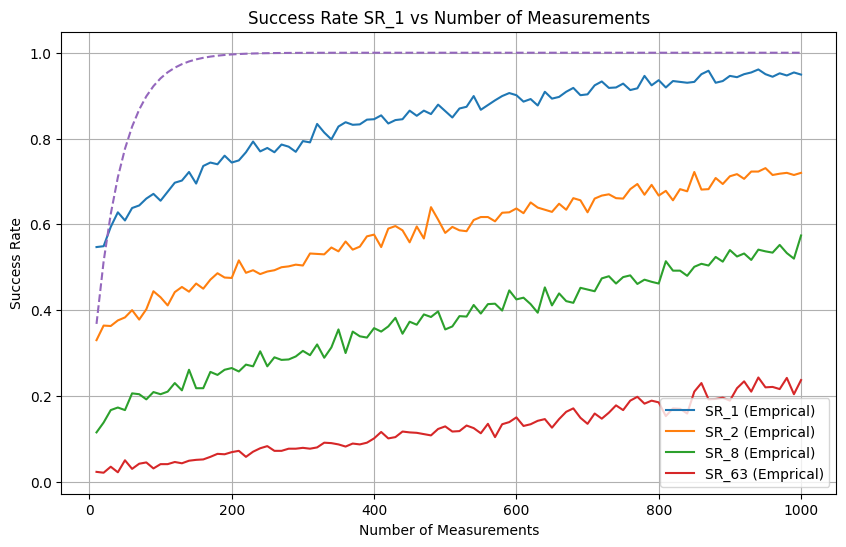

In [32]:
# Plot SR_63
import pickle
import matplotlib.pyplot as plt

with open("emprical_sr.pkl", "rb") as f:
    data = pickle.load(f)

# Number of measurements
n_measurements = range(10, 1001, 10)

sr_sets = {
    "SR_1": (kc, [0]),
    "SR_2": (kc, [0,1]),
    "SR_8": (kc, [0,1,2,3,5,6,7,8]), # skip 4 since it is kc
    "SR_63": (kc, [k for k in range(64) if k != kc])
}

plt.figure(figsize=(10, 6))
for sr in sr_sets:
    plt.plot(n_measurements, sr_data[sr], label=f"{sr} (Emprical)")
plt.plot(n_measurements, success_rate_sr63, "--")
plt.xlabel("Number of Measurements")
plt.ylabel("Success Rate")
plt.title("Success Rate SR_1 vs Number of Measurements")
plt.legend()
plt.grid()
plt.show()